# Shifted Quadratic

# Imports

In [195]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import NumericalContinuousParameter, TaskParameter
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from baybe.utils.plotting import create_example_plots

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [196]:
import baybe
baybe.__version__

'0.8.1.post24'

# Settings

In [197]:
NRELEVANT_DIM = 3  # number of relevant dimensions
NNOISE_DIM = 0  # number of noise dimensions
DIMENSION = NRELEVANT_DIM + NNOISE_DIM  # total number of dimensions
BATCH_SIZE = 1  # batch size of recommendations per DOE iteration
N_MC_ITERATIONS = 50  # number of Monte Carlo runs
N_DOE_ITERATIONS = 18 # number of DOE iterations

# Creating the Relevant Objects

In [198]:
objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="Target", mode="MIN")]
)

bound_scale = 50
BOUNDS = bound_scale * np.array([[-1.0, 1.0] for _ in range(DIMENSION)]).T

design_params = [
    NumericalContinuousParameter(
        name=f"x{d}",
        bounds=(lower, upper),
    )
    for d, (lower, upper) in enumerate(BOUNDS.T)
]

task_param = TaskParameter(
    name="Function",
    values=["Target", "Source"],
    active_values=["Target"],
)

parameters = [*design_params, task_param]
searchspace = SearchSpace.from_product(parameters=parameters)

# Defining the Lookup

In [199]:
# Truncated square function
def make_truncated_square(        
    ndim: int,
    noise_std: float = 0.0,
    nnoise_dim: int = 0,
    truncation_radius: float = 1.0,
    take_root: bool = False,
    negated: bool = False
    ) -> callable:
    
    def fun(*x: float) -> float:
        """Calculate a truncated square function in the first ndim-nnoise_dim dimensions."""
        
        x = np.array(x)
        if len(x.shape) == 1 and isinstance(x[0], str):
            x = x[1:].astype(float)
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        if len(x.shape) == 2 and isinstance(x[0, 0], str):
            x = x[:, 1:].astype(float)
        
        if nnoise_dim == 0:
            out = np.sum(x**2, axis=-1)
        else:
            out = np.sum(x[..., : -nnoise_dim] ** 2, axis=-1)
        out[out < truncation_radius**2] = truncation_radius**2
        if take_root:
            out = np.sqrt(out)
        if negated:
            out = -out
        return out + noise_std * np.random.randn(*out.shape)
    
    return fun

test_functions = {
    "Target": make_truncated_square(ndim=DIMENSION, noise_std=0.0, nnoise_dim=NNOISE_DIM, truncation_radius=0.0, take_root=True),
    "Source": make_truncated_square(ndim=DIMENSION, noise_std=5.0, nnoise_dim=NNOISE_DIM, truncation_radius=35.0, take_root=True),
}

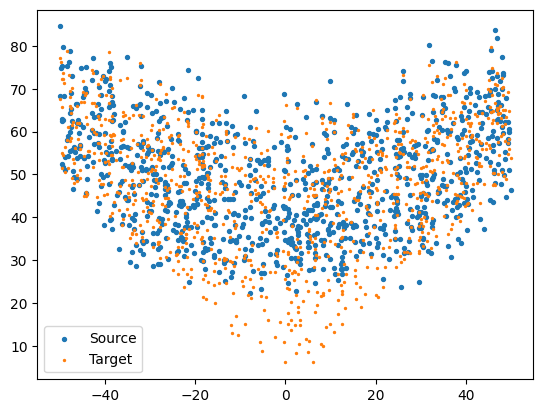

In [200]:
x = np.random.uniform(-bound_scale, bound_scale, (1000, DIMENSION))
y1 = test_functions["Source"](*x)
y2 = test_functions["Target"](*x)
plt.scatter(x[:,0], y1, 8);
plt.scatter(x[:,0], y2, 2);
plt.legend(['Source','Target']);

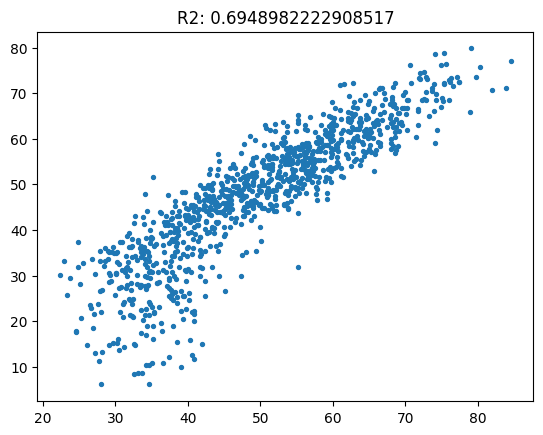

In [201]:
plt.scatter(y1, y2, 8);
plt.title(f'R2: {r2_score(y1, y2)}');

# Create scenarios

In [202]:
base_scenario = {'Baseline': Campaign(searchspace=searchspace, objective=objective)}
scenarios = {}
initial_datas = {}
n_init_data_for_tl_list = [10, 20, 50, 100]

for n_init_data_for_tl in n_init_data_for_tl_list:
    campaign_tl = Campaign(searchspace=searchspace, objective=objective)
    scenarios[f"TL_{n_init_data_for_tl}"] = campaign_tl
    initial_datas[f"TL_{n_init_data_for_tl}"] = []
    
    for _ in range(N_MC_ITERATIONS):    
        # Generate training data points for the source task
        x_init = np.random.uniform(-bound_scale, bound_scale, (n_init_data_for_tl, DIMENSION))
        y_init = test_functions["Source"](*x_init)

        df_init = pd.DataFrame(x_init, columns=[f"x{d}" for d in range(DIMENSION)])
        df_init["Function"] = "Source"
        df_init["Target"] = y_init
        
        initial_datas[f"TL_{n_init_data_for_tl}"].append(df_init)

# Run Backtest

In [203]:
import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame()

for key in scenarios:
    result = simulate_scenarios(
        {key: scenarios[key]},
        test_functions["Target"],
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        initial_data=initial_datas[key]
    )
    results = pd.concat([results, result], ignore_index=True)
    
result = simulate_scenarios(
    base_scenario,
    test_functions["Target"],
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS
)
results = pd.concat([results, result], ignore_index=True)

100%|#############################################################################################################################################################################| 50/50 [03:42<00:00,  4.45s/it]


# Visualize Results

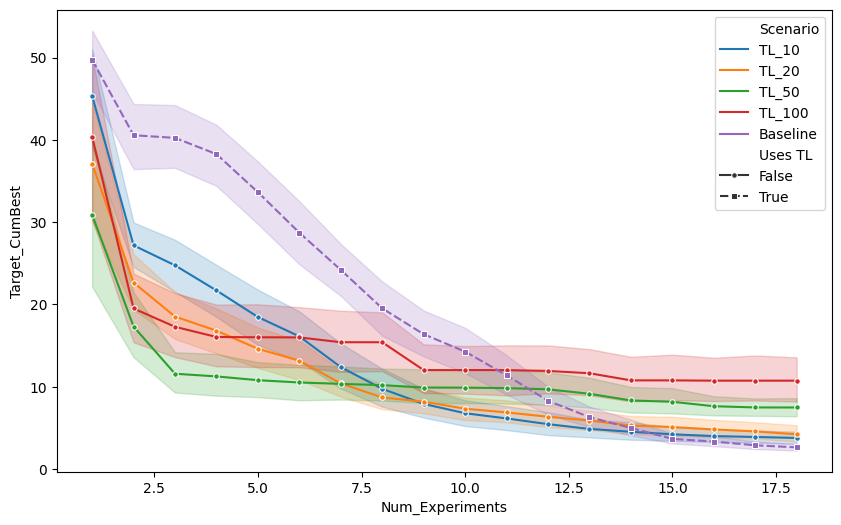

In [204]:
# Add column to enable different styles for non-TL examples
results["Uses TL"] = results["Scenario"].apply(lambda val: "TL_" not in val)
path = Path(sys.path[0])
ax = sns.lineplot(
    data=results,
    markers=["o", "s"],
    markersize=4,
    x="Num_Experiments",
    y="Target_CumBest",
    hue="Scenario",
    style="Uses TL",
)
plt.gcf().set_size_inches((10,6))
plt.show()

# create_example_plots(
#     ax=ax,
#     path=path,
#     base_name="backtesting",
# )